МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Объектом можетбыть любой набор, который нужно упорядочить. Чаще всего это документы, которые должны соответствовать запросам. Целевые метки -- пары объектов $(x_i, x_j)$, про которые известно, что $x_i < x_j$. Сравнимые объекты -- относящиеся к частично упорядоченному множетсву.

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

Метрика nDCG допускает вещественные оценки релевантности. 

**3.** Почему говорят, что все основные метрики качества дискретны?

Потому что  всего конечное количество способов упорядочить объекты.

**4.** В чем преимущество факторизации в модели RankNet?

Ускоряет обучение (от квадратного времени перешли к линейному).

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

Вместо дискретной метрики градиентным спуском оптимизируется гладкая функция с тем же градиентом.

**6.** Какое преобразование данных используется в модели RankSVM?

N-классовое ранжирование преобразовывается в бинарную классификацию, также называемую попарным ранжированием.

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

Вместо V станет V-1. То есть $p_{ij}$ увеличится. Тогда увеличится и $\varepsilon$. Применив эргодическую теорему, понимаем, что скорость сходимости возрастет.

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

С точки зрения теории нет, так как сходимость всегда к одному распределению. С точки зрения практики на разных распределениях схродимость с разной скоростью, поэтому есть смысл перебрать несколько вариантов и выбрать тот, которых быстрее сходится. 

# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

1) $\frac{p}{|V|} + x \geq \frac{p}{|V|}$ , $x = \frac{1-p}{|V|}I(url_j,url_i)$ , $x \geq 0$

2) $p \leq 1$ => $\frac{1}{|V|} \geq \frac{p}{|V|}$

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

Казалось бы, что можно, если задать состояние как пару (предыдущая страница, текущая страница).
Переход от одной пары к следующей не зависит от истории. Как строго доказать, не знаю, но как-то наверняка считаются вероятности. 

## Часть 1

In [ ]:
import matplotlib
matplotlib.use('PS')
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True
import pylab as plt
plt.switch_backend('PS')

In [183]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import random
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)
# plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
# plt.rc('font', family='serif', size='16')

Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [259]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
        
    assert N > 0
    
   
    prob_matrix = np.zeros((N, N))
    for i, j in links:
        prob_matrix[i][j] = 1
        
    N_i = [np.sum(prob_matrix[i]) for i in range(N)]
    prob_matrix = np.array([np.array([(1 - damping_factor) / N_i[i] * prob_matrix[i][j] + damping_factor / N if N_i[i] 
                                      else 1. / N for j in range(N)]) for i in range(N)])
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False, num_iters=None):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor)
    distribution = start_distribution.copy()
    
    trace = [distribution]
    
    iter = 0
    while(True):
        old_distribution = distribution
        distribution =  old_distribution.dot(prob_matrix)
        trace.append(distribution)
        iter += 1
        if num_iters != None and iter == num_iters:
            break

        if np.sum((old_distribution - distribution) ** 2) <= tolerance:
            break
        
        
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
def random_graph(n, p):
    return [(i, j) for i in range(n) for j in range(n) if i != j 
            and random.choice(np.concatenate([np.zeros((100 - p * 100,)), np.ones((p * 100,))]))]

Теперь сгенерируем случайный граф и нарисуем его.

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


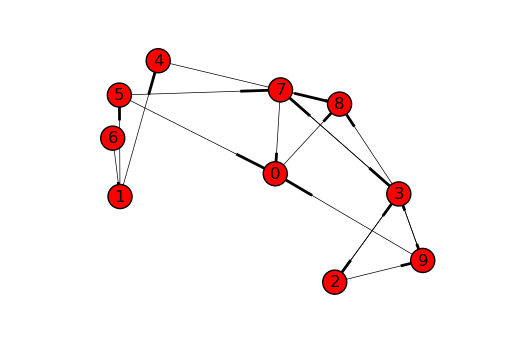

In [316]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


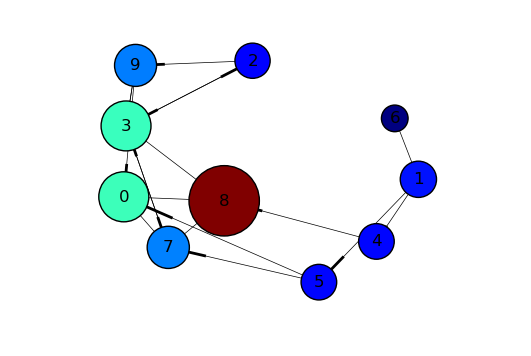

In [317]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

In [82]:
def power(eps, n):
    return [ eps ** i for i in range(1, n + 1)]        

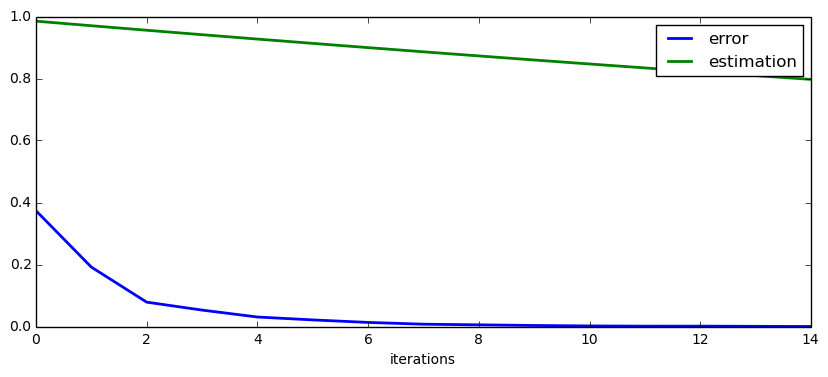

In [96]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
estimation = power(1 - np.min(create_page_rank_markov_chain(edges)), len(errors))
plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimation, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

<Выводы>

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины? (От весов вершин, которые на нее ссылаются)

<Исследования и выводы>

In [177]:
def plot_convergence(N, p, start_distribution=None):
    edges = random_graph(N, p)
    
    if start_distribution == None:
        start_distribution = np.ones((1, N)) / N
    pr_distribution = page_rank(edges, start_distribution)

    pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                          return_trace=True)
    errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
    estimation = power(1 - np.min(create_page_rank_markov_chain(edges)), len(errors))
    plt.figure(figsize=(10, 4))
    x = np.arange(len(errors))
    plt.plot(x, errors, lw=2, label='error')
    plt.plot(x, estimation, lw=2, label='estimation')
    plt.legend()
    plt.xlabel('iterations=' + str(len(errors)))
    plt.show()

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


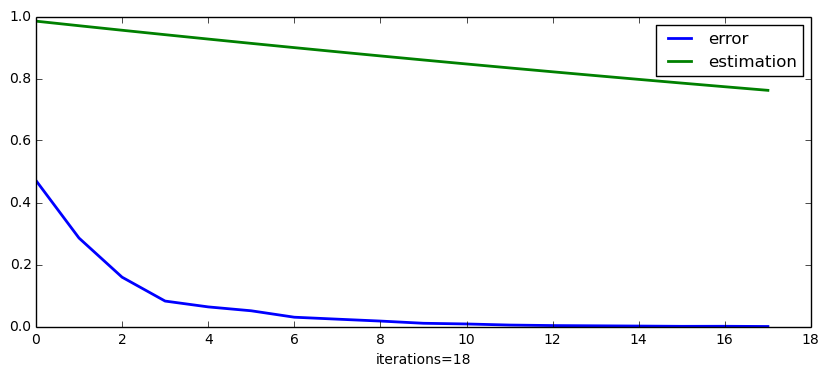

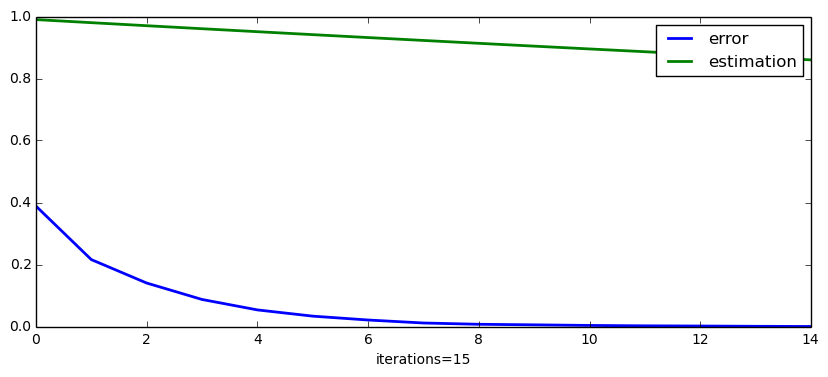

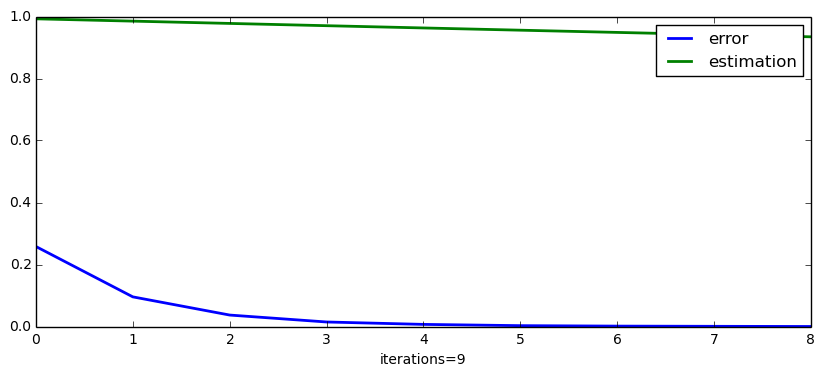

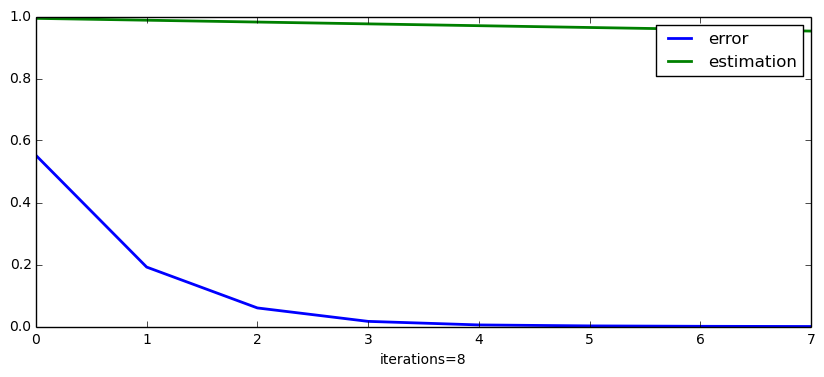

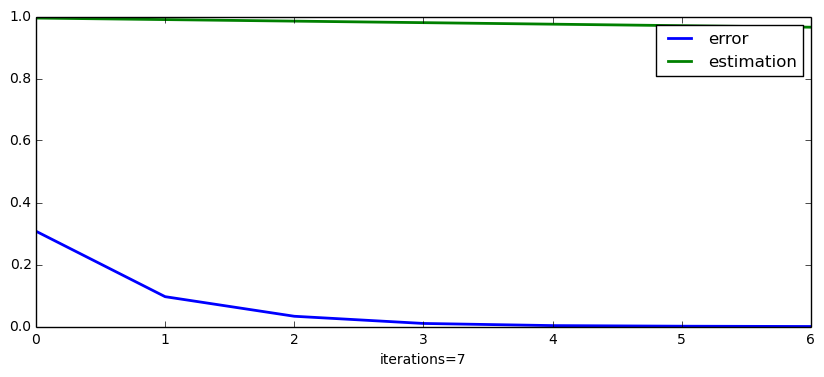

In [325]:
for i in range(10, 31, 5):
    plot_convergence(i, 0.2)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


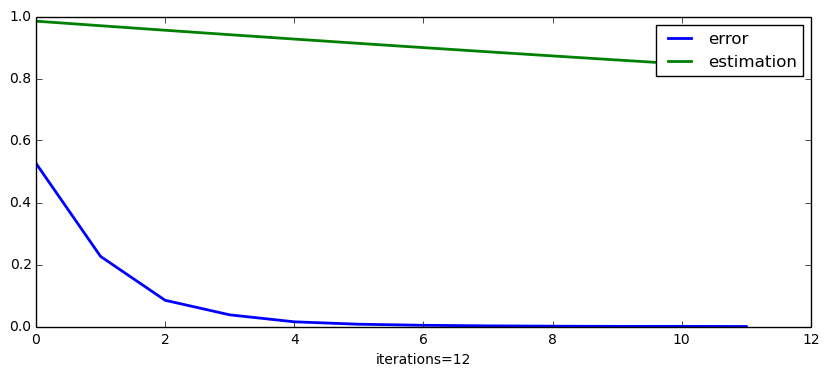

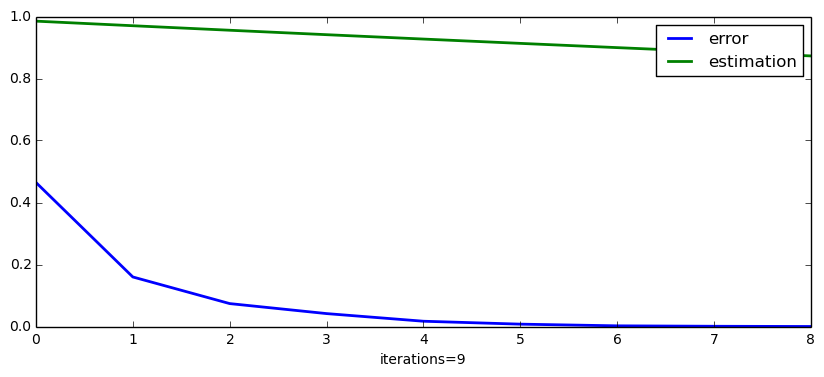

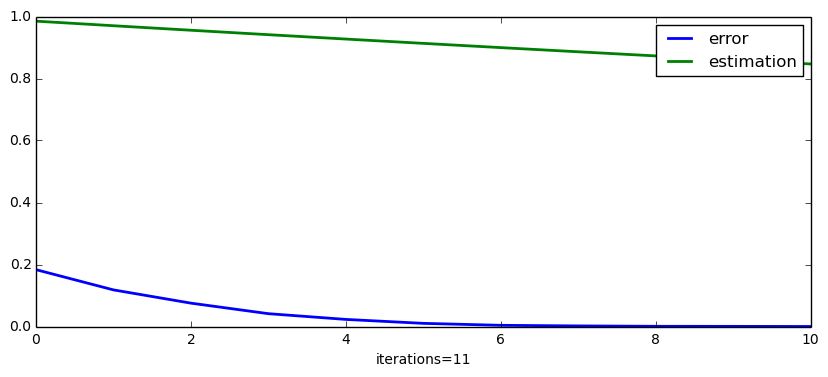

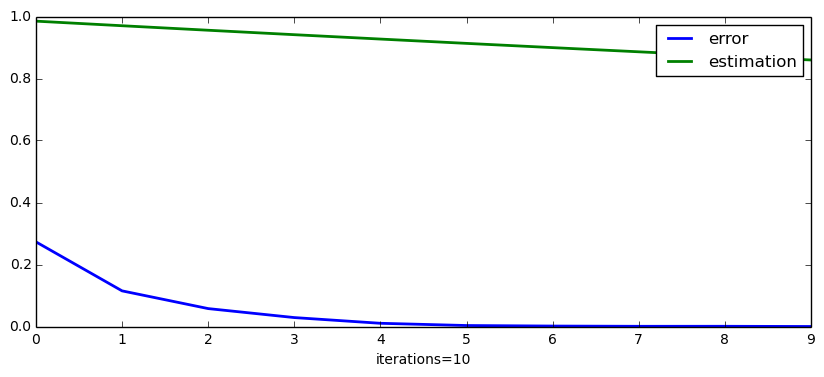

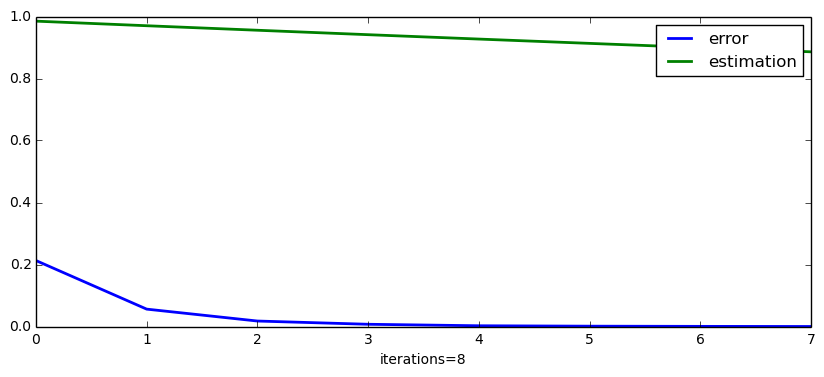

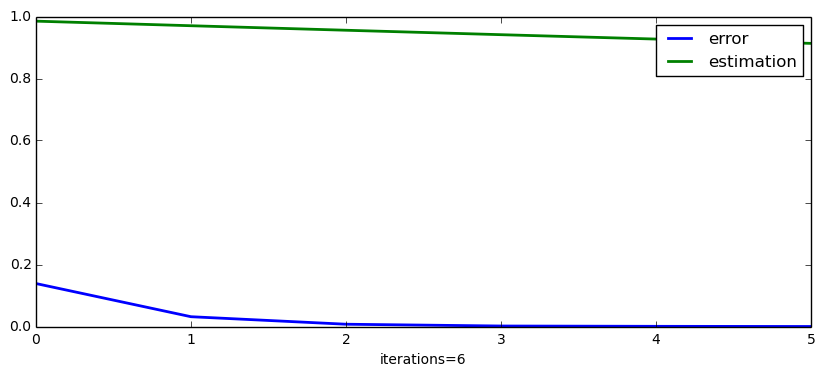

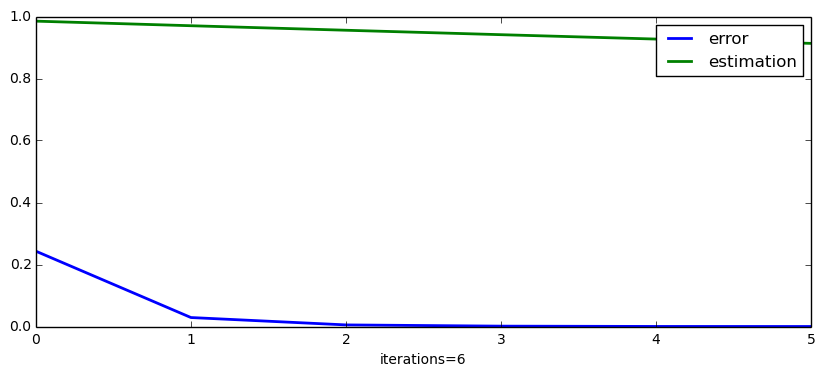

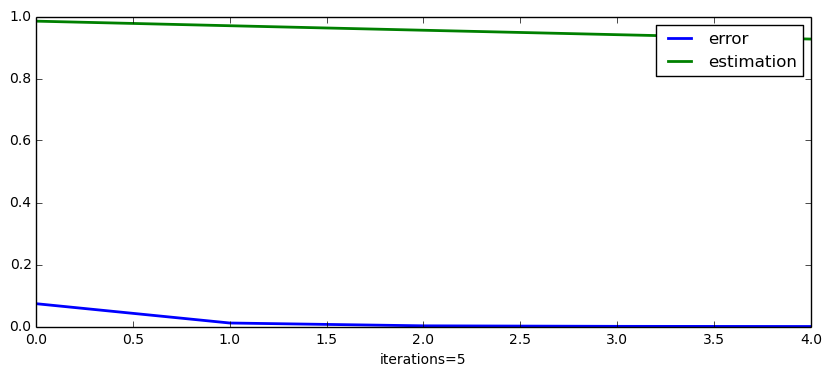

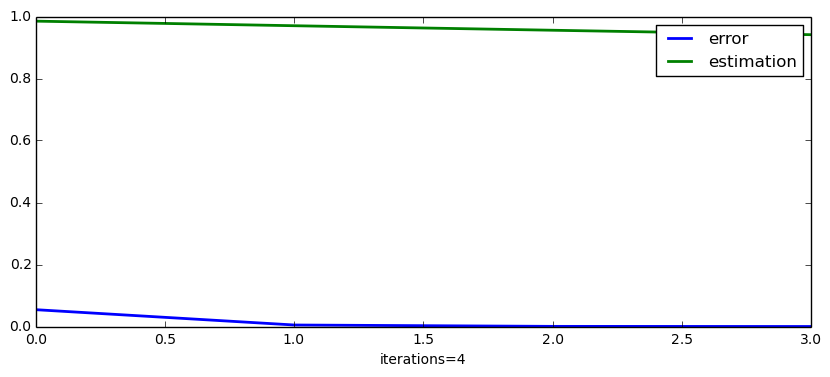

In [318]:
for i in np.linspace(0.1, 0.9, 9):
    plot_convergence(10, i)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


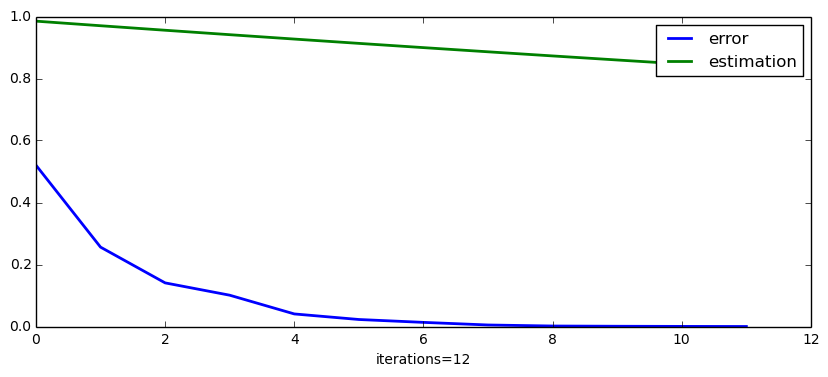

In [155]:
plot_convergence(10, 0.2, np.array([[0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]]))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


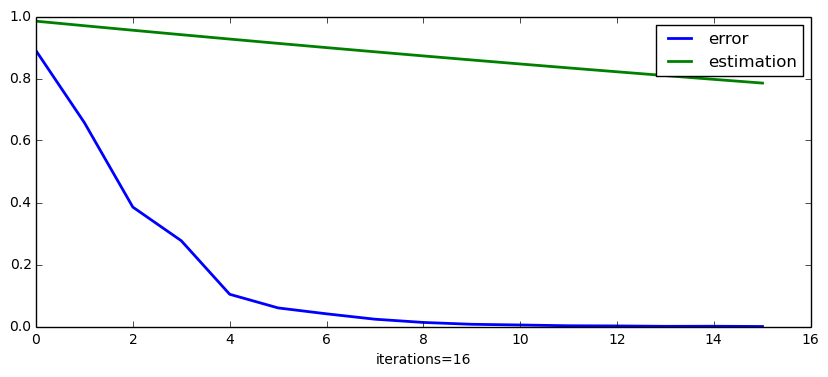

In [157]:
plot_convergence(10, 0.2, np.array([[0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


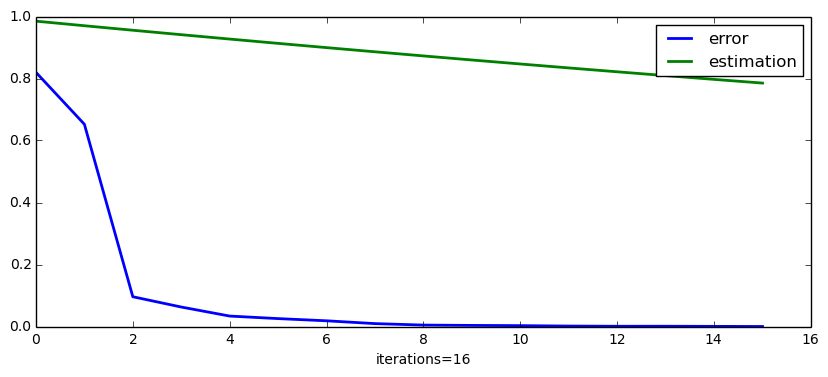

In [154]:
plot_convergence(10, 0.2, np.array([[0.5, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


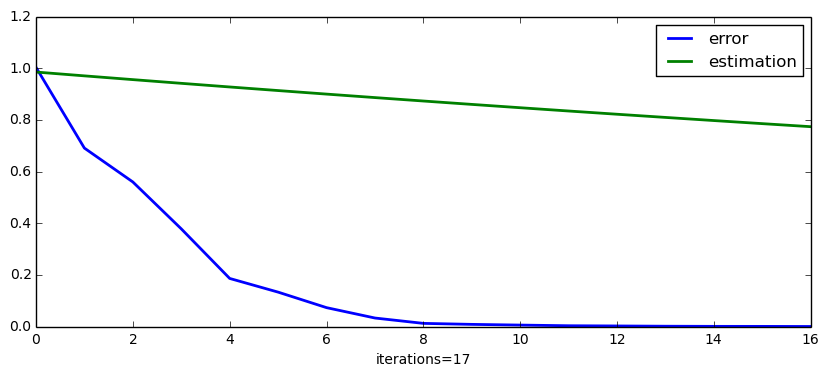

In [179]:
plot_convergence(10, 0.2, np.array([[0.6, 0.07, 0.07, 0.06, 0.06, 0.02, 0.02, 0.02, 0.02, 0.02]]))

Выводы:

1. Сходимость больше при росте графа

2. Сходимость больше при уплотнении графа

3. Сходимость меньше при смещении начального распределения

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [97]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [326]:
urls = ['https://yandexdataschool.ru/']
site = get_site(urls[0])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


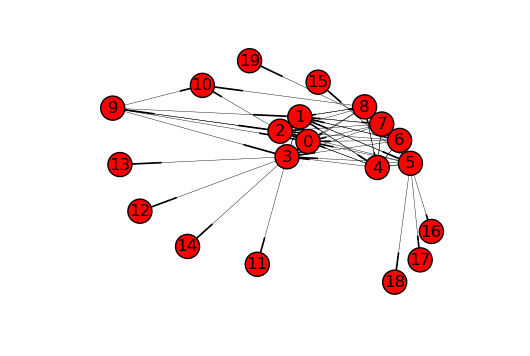

In [327]:
G = networkx.DiGraph()
G.add_edges_from(links)
plt.axis('off')
networkx.draw_networkx(G, width=0.3)

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


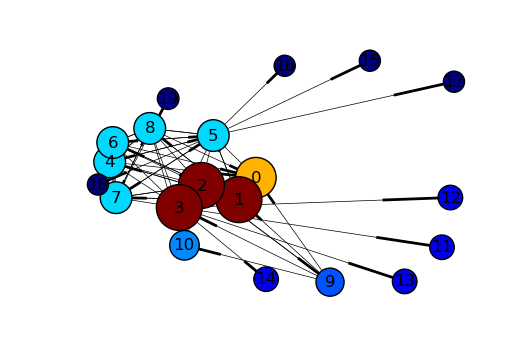

In [328]:
N = np.array(links).max() + 1
start_distribution = np.ones((1, N)) / N
pr_distribution, pr_trace = page_rank(links, start_distribution, return_trace=True)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

array([[<matplotlib.axes.AxesSubplot object at 0x7fdec8a3e7b8>]], dtype=object)

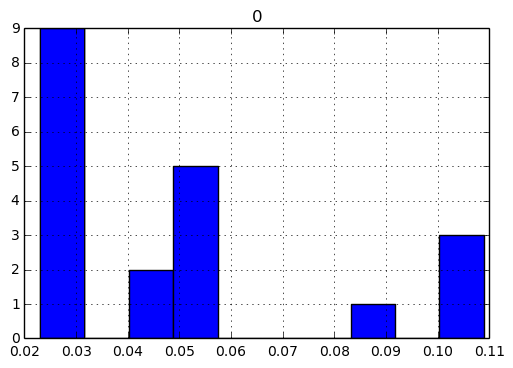

In [196]:
pd.DataFrame(pr_distribution).hist()

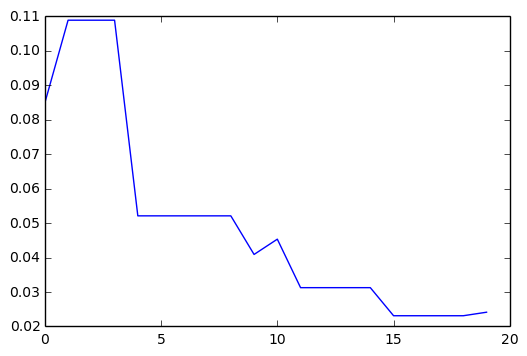

In [202]:
plt.plot(pr_distribution)
plt.show()

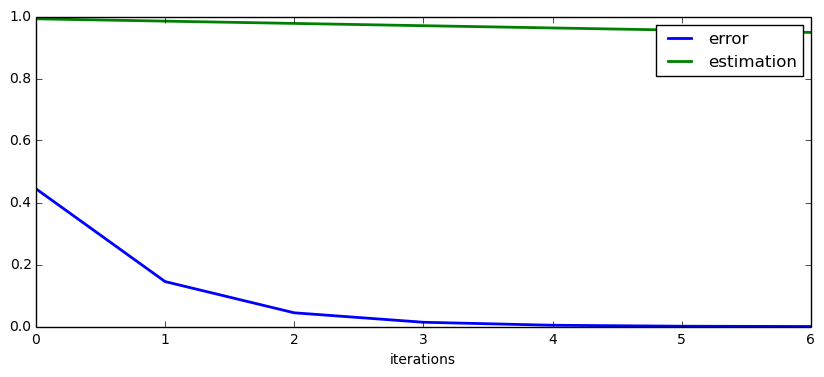

In [208]:
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
estimation = power(1 - np.min(create_page_rank_markov_chain(links)), len(errors))
plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimation, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

In [214]:
urls

['https://yandexdataschool.ru/',
 'https://yandexdataschool.ru/about',
 'https://yandexdataschool.ru/admission',
 'https://yandexdataschool.ru/edu-process',
 'https://yandexdataschool.ru/about/administration',
 'https://yandexdataschool.ru/about/branches',
 'https://yandexdataschool.ru/about/collaborations',
 'https://yandexdataschool.ru/about/graduates',
 'https://yandexdataschool.ru/about/contacts',
 'https://yandexdataschool.ru/admission/faq',
 'mailto://yandexdataschool.ru/shad@yandex-team.ru',
 'https://yandexdataschool.ru/edu-process/program',
 'https://yandexdataschool.ru/edu-process/teachers',
 'https://yandexdataschool.ru/edu-process/courses',
 'https://yandexdataschool.ru/edu-process/schedule',
 'https://yandexdataschool.ru/about/branches/minsk',
 'https://yandexdataschool.ru/about/branches/kiev',
 'https://yandexdataschool.ru/about/branches/novosibirsk',
 'https://yandexdataschool.ru/about/collaborations#computersciencecentervsankt-peterburge',
 'https://yandexdataschool.ru/

In [227]:
pr_distribution[:10]

array([ 0.08487477,  0.10891011,  0.10891011,  0.10891011,  0.0521092 ,
        0.0521092 ,  0.0521092 ,  0.0521092 ,  0.0521092 ,  0.04090223])

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


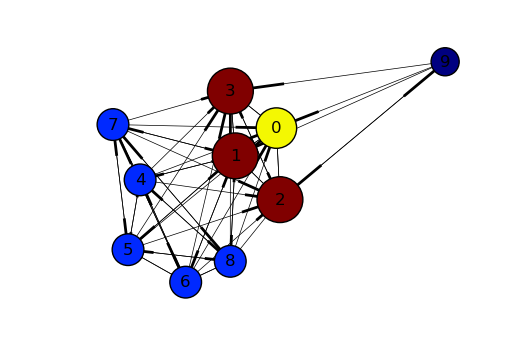

In [330]:
new_links = [(i, j) for i, j in links if i in range(10) and j in range(10)]

G = networkx.DiGraph()
G.add_edges_from(new_links)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution[:10],
                       node_color=pr_distribution[:10])

Страницы с наибольшим pagerank-ом - те, на которые можно попасть с главной. Главная страница имеет второй по величине pagerank, что вполне очевидно, так как на нее в основном ведут ссылки со многих других страниц. 

Посмотрим, что будет, если не доводить итерационный процесс до сходимости: 

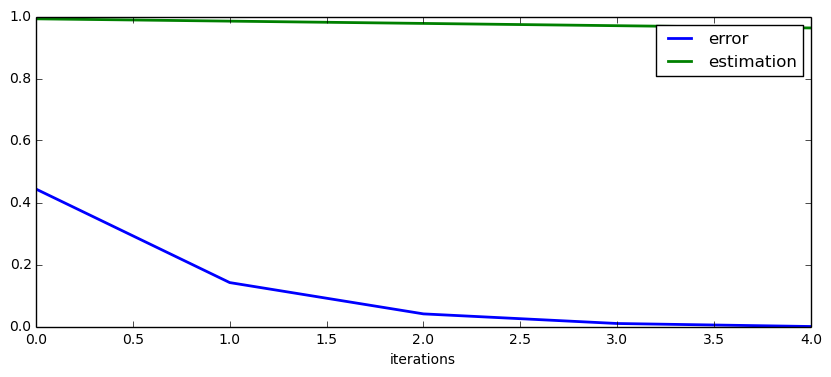

In [270]:
G = networkx.DiGraph()
G.add_edges_from(links)

N = np.array(links).max() + 1
start_distribution = np.ones((1, N)) / N
pr_distribution, pr_trace = page_rank(links, start_distribution, return_trace=True, num_iters=4)

errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
estimation = power(1 - np.min(create_page_rank_markov_chain(links)), len(errors))
plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimation, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


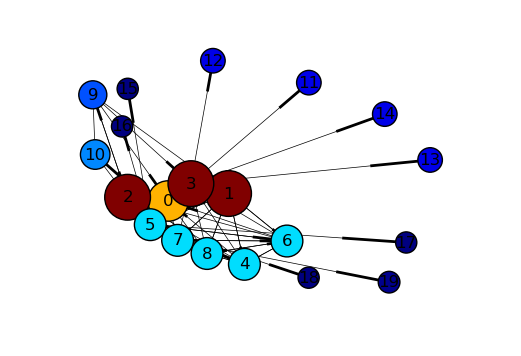

In [271]:
size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Выглядит так, будто мы можем взять и меньшее количество итераций, и все равно получим нужный нам page rank

In [246]:
urls = ['http://grantist.com']
site = get_site(urls[0])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


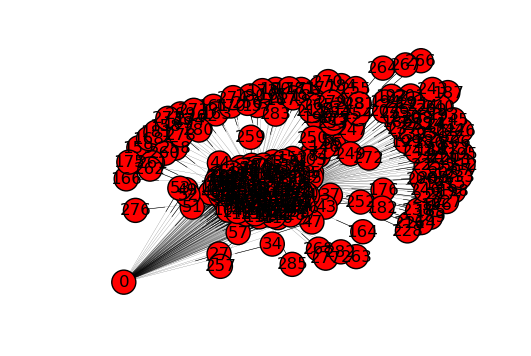

In [256]:
G = networkx.DiGraph()
G.add_edges_from(links)
plt.axis('off')
networkx.draw_networkx(G, width=0.1)

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


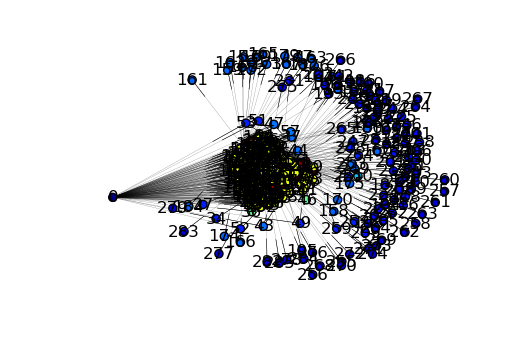

In [257]:
N = np.array(links).max() + 1
start_distribution = np.ones((1, N)) / N
pr_distribution, pr_trace = page_rank(links, start_distribution, return_trace=True)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

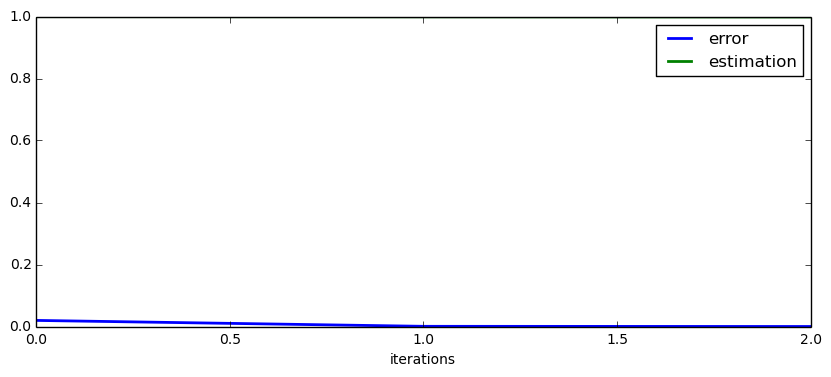

In [255]:
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
estimation = power(1 - np.min(create_page_rank_markov_chain(links)), len(errors))
plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimation, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

Пример типичного информационного портала с начальной страницей, из которой ведет много ссылок на другие, но на нее не ссылаются. Часть страниц между собой взаимосвязаны, поэтому у нах PR больше, остальные же просто одинокие вершины с одним входящим ребром. Для такого графа PR будет считаться быстро

## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [284]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines])))
        values.append(block_values)
        text = text[index:]
        
    return values

def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[-1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:-2]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)


def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')
            

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

In [285]:
relevs, qids, features = read_file('imat2009-datasets/imat2009_learning.txt', 250)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [286]:
split_to_train_valid_test(rel, qid, features, 'imat2009-datasets/train.txt', 'imat2009-datasets/test.txt', 
                          0.1, 0.1, valid_path='imat2009-datasets/valid.txt', valid_size=0.1)

In [289]:
%%time
! java -jar RankLib-2.1-patched.jar -train imat2009-datasets/train.txt -test imat2009-datasets/test.txt -validate imat2009-datasets/valid.txt -ranker 0 \
-tree 300 -leaf 5 -metric2t NDCG@10 -save model/MART_300_5.txt > model/log_MART_300_5.txt

CPU times: user 1.24 s, sys: 136 ms, total: 1.37 s
Wall time: 51 s


In [297]:
%%time
! java -jar RankLib-2.1-patched.jar -train imat2009-datasets/train.txt -test imat2009-datasets/test.txt -validate imat2009-datasets/valid.txt -ranker 6 \
-tree 300 -leaf 5 -metric2t NDCG@10 -save model/LambdaMART_300_5.txt > model/log_LambdaMART_300_5.txt

CPU times: user 1.29 s, sys: 176 ms, total: 1.46 s
Wall time: 54.7 s


Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

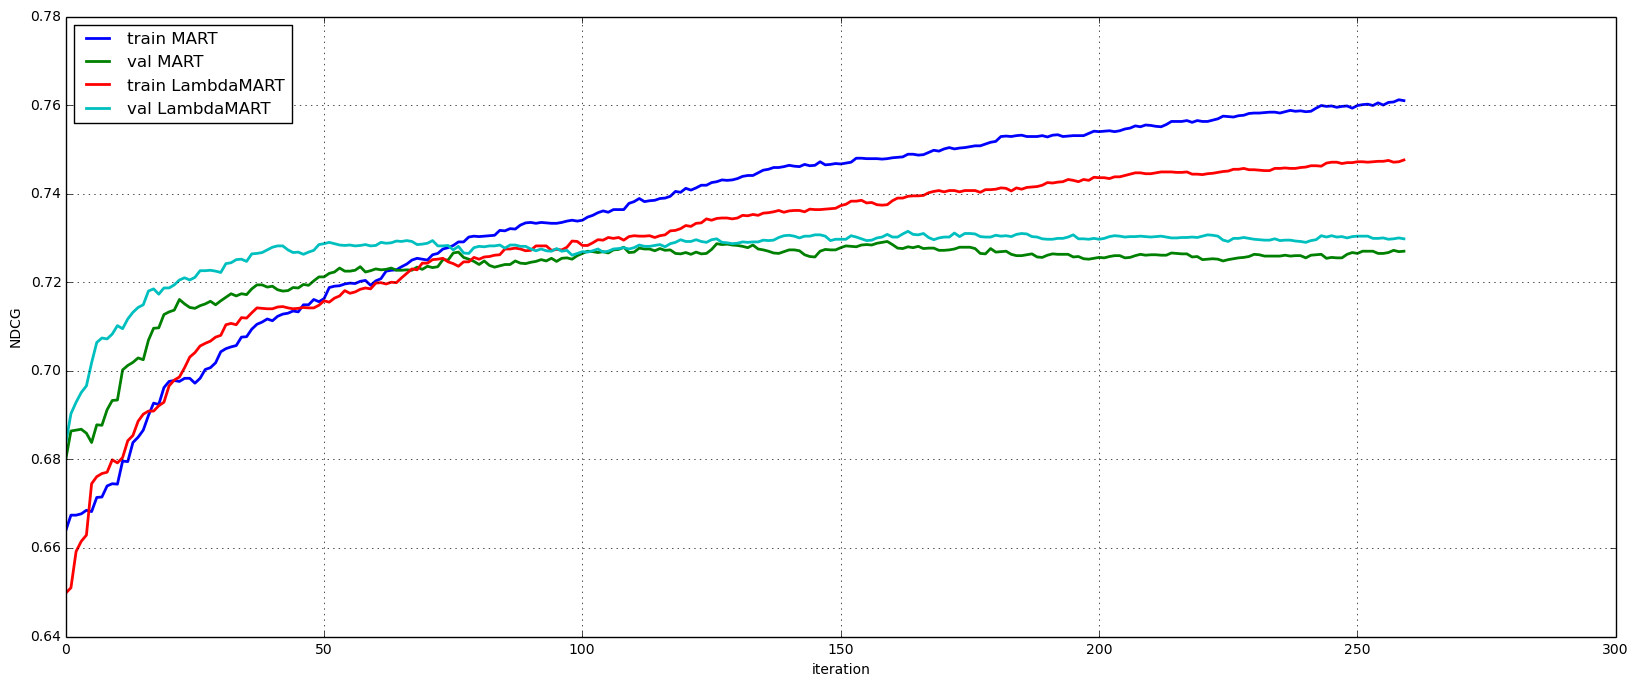

In [298]:
values = (read_metric_dependence_from_file('model/log_LambdaMART_300_5.txt', 300)[0],
          read_metric_dependence_from_file('model/log_MART_300_5.txt', 300)[0])

plt.figure(figsize=(20, 8))
plt.plot(range(260), [values[0][i][1] for i in range(260)] , lw=2, label='train MART')
plt.plot(range(260), [values[0][i][2] for i in range(260)] , lw=2, label='val MART')
plt.plot(range(260), [values[1][i][1] for i in range(260)] , lw=2, label='train LambdaMART')
plt.plot(range(260), [values[1][i][2] for i in range(260)] , lw=2, label='val LambdaMART')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('MART and LambdaMART')
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?  

<Ответ>
<b>Судя по NDCG на валидационной выобрке  LambdaMART работает чуть лучше. Переобучение не наблюдается. </b>

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

In [299]:
%%time
! java -jar RankLib-2.1-patched.jar -train imat2009-datasets/train.txt -test imat2009-datasets/test.txt -validate imat2009-datasets/valid.txt -ranker 1 \
-epoch 300 -metric2t NDCG@10 -save model/RankNet_300_5.txt > model/log_RankNet_300_5.txt

CPU times: user 7.6 s, sys: 1.07 s, total: 8.67 s
Wall time: 6min 23s


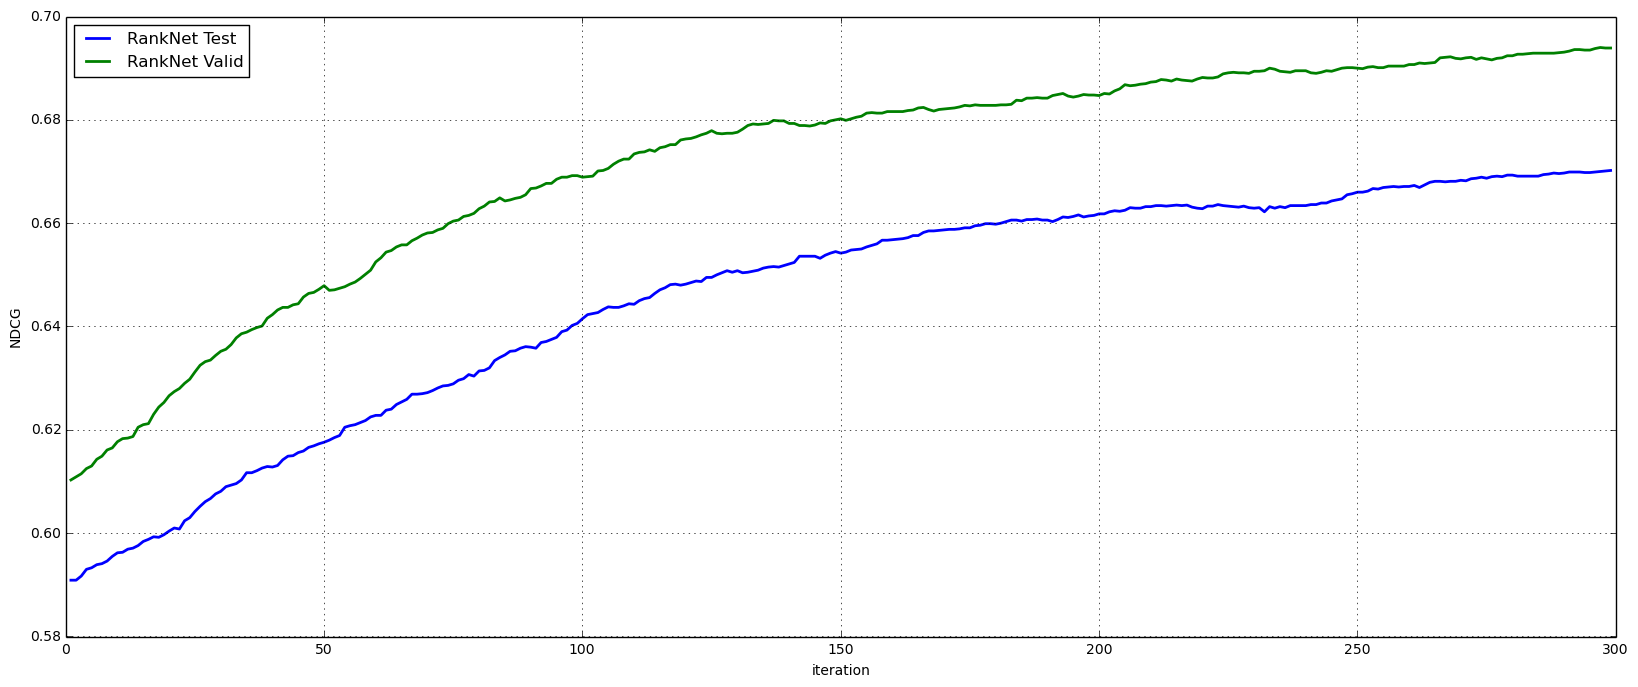

In [300]:
values = read_metric_dependence_from_file('model/log_RankNet_300_5.txt', 300)[0]

plt.figure(figsize=(20, 8))
plt.plot(range(1, len(values)), [values[i][2] for i in range(1, len(values))] , lw=2, label='RankNet Test')
plt.plot(range(1, len(values)), [values[i][3] for i in range(1, len(values))] , lw=2, label='RankNet Valid')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('Ranking Net')
plt.legend(loc=2)
plt.grid()
plt.show()

на Random Foreste все очень странно и подозрительно долго считается

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ> <b>Нечестный, так как мы не перебираем все возможные пары разбиений, ведь у нас один запрос может оказываться в одной и той же части.
</b>

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [305]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:-1]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

In [306]:
train = list()
test = list()

for i in range(10):

    ! java -cp RankLib-2.1-patched.jar ciir.umass.edu.features.FeatureManager \
        -input imat2009-datasets/train.txt -output imat2009-datasets/ -shuffle 
        
    relevs, qids, features = read_file('imat2009-datasets/train.txt.shuffled', 251)
    
    split_to_train_valid_test(relevs, qids, features, 'imat2009-datasets/train1.txt', 'imat2009-datasets/train2.txt', 0.5, 0.5)

    ! java -jar RankLib-2.1-patched.jar -train imat2009-datasets/train1.txt -test imat2009-datasets/test.txt \
        -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save model/LambdaMART_smoothing.txt > model/log_LambdaMART_smoothing.txt
    
    result_train = read_metric_dependence_from_file('model/log_LambdaMART_smoothing.txt', 300)[0]
    train.append(result_train)

    with open('model/LambdaMART_smoothing.txt') as f:
        model = f.readlines()

    result_test = list()
    for i in range(1, 300):
        tree_index = model.index('\t<tree id="{}" weight="0.1">\n'.format(i+1))
        
        with open('model/MyModel_smoothing.txt', 'w') as f:
            f.write(''.join(model[:tree_index]))
            f.write(model[-1])
        
        ! java -jar RankLib-2.1-patched.jar -load model/ConstructedModel_smoothing.txt -test imat2009-datasets/test.txt \
            -metric2T NDCG@10  > model/log_ConstructedModel_smoothing.txt
        
        with open('model/log_MyModel_smoothing.txt') as f:
            test = f.readlines()
        
        result_test.append(float(test[-1].split(': ')[1]))
    
    ! java -jar RankLib-2.1-patched.jar -load model/LambdaMART_smoothing.txt -test imat2009-datasets/test.txt \
        -metric2T NDCG@10 > model/log_ConstructedModel_smoothing.txt
    
    with open('model/log_MyModel_smoothing.txt') as f:
        test= f.readlines()
        
    result_test.append(float(test[-1].split(': ')[1]))
    test.append(result_test)

Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [imat2009-datasets/train.txt]... [Done.]            
(938 ranked lists, 9847 entries 

In [310]:
train_array = np.array([[line[1] for line in arr if line != []] for arr in train])
train_mean = train_array.mean(axis=0)
test_array = np.array(test)
test_mean = test_array.mean(axis=0)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


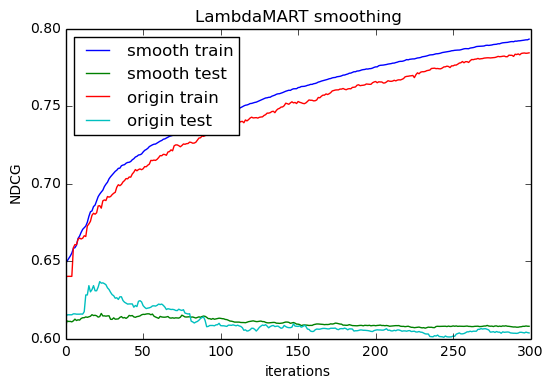

In [315]:
plt.plot(train_mean, label='smooth train')
plt.plot(test_mean, label='smooth test')
plt.plot(train_array[0], label='origin train')
plt.plot(test_array[0], label='origin test')
plt.legend(loc=2)
plt.title('LambdaMART smoothing')
plt.ylabel('NDCG')
plt.xlabel('iterations')
plt.show()